In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

ecg-heart-categorization-dataset-image-version.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
!rm /content/ECG_Image_data/train/F/*
!rmdir /content/ECG_Image_data/train/F

In [8]:
!rm /content/ECG_Image_data/test/F/*
!rmdir /content/ECG_Image_data/test/F

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from tensorflow.keras.layers import Input, Average

In [10]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [11]:
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/V/2721.jpg,V
1,/content/ECG_Image_data/train/V/2816.jpg,V
2,/content/ECG_Image_data/train/V/4296.jpg,V
3,/content/ECG_Image_data/train/V/1498.jpg,V
4,/content/ECG_Image_data/train/V/5199.jpg,V
...,...,...
97131,/content/ECG_Image_data/train/F-resample/539.jpg,F-resample
97132,/content/ECG_Image_data/train/F-resample/1880.jpg,F-resample
97133,/content/ECG_Image_data/train/F-resample/726.jpg,F-resample
97134,/content/ECG_Image_data/train/F-resample/1530.jpg,F-resample


In [12]:
dataframe['Label'].value_counts()

N             72471
M              8000
Q              6431
V              5788
S              2223
F-resample     2223
Name: Label, dtype: int64

In [13]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(1600, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

F-resample    1600
V             1600
Q             1600
S             1600
M             1600
N             1600
Name: Label, dtype: int64

In [14]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/F-resample/1476.jpg,F-resample
1,/content/ECG_Image_data/train/V/1884.jpg,V
2,/content/ECG_Image_data/train/Q/3252.jpg,Q
3,/content/ECG_Image_data/train/F-resample/2053.jpg,F-resample
4,/content/ECG_Image_data/train/V/5466.jpg,V
...,...,...
9595,/content/ECG_Image_data/train/S/1091.jpg,S
9596,/content/ECG_Image_data/train/M/2340.jpg,M
9597,/content/ECG_Image_data/train/V/4936.jpg,V
9598,/content/ECG_Image_data/train/Q/6144.jpg,Q


In [15]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/V/359.jpg,V
1,/content/ECG_Image_data/test/V/1409.jpg,V
2,/content/ECG_Image_data/test/V/753.jpg,V
3,/content/ECG_Image_data/test/V/1155.jpg,V
4,/content/ECG_Image_data/test/V/619.jpg,V
...,...,...
24787,/content/ECG_Image_data/test/M/2436.jpg,M
24788,/content/ECG_Image_data/test/M/1530.jpg,M
24789,/content/ECG_Image_data/test/M/46.jpg,M
24790,/content/ECG_Image_data/test/M/2381.jpg,M


In [16]:
dataframe_test['Label'].value_counts()

N              18118
M               2506
Q               1608
V               1448
S                556
F-resampled      556
Name: Label, dtype: int64

In [17]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(400, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

F-resampled    400
S              400
M              400
N              400
V              400
Q              400
Name: Label, dtype: int64

In [18]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F-resampled/68.jpg,F-resampled
1,/content/ECG_Image_data/test/S/387.jpg,S
2,/content/ECG_Image_data/test/F-resampled/244.jpg,F-resampled
3,/content/ECG_Image_data/test/M/2047.jpg,M
4,/content/ECG_Image_data/test/N/9183.jpg,N
...,...,...
2395,/content/ECG_Image_data/test/N/4261.jpg,N
2396,/content/ECG_Image_data/test/N/7479.jpg,N
2397,/content/ECG_Image_data/test/N/1071.jpg,N
2398,/content/ECG_Image_data/test/V/1161.jpg,V


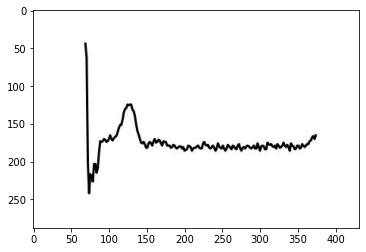

In [19]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [20]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    #shear_range = 0.2,
    #horizontal_flip=True,
    #zoom_range = 0.2,
    validation_split=0.25
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [22]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7200 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


In [23]:
test_generator.class_indices

{'F-resampled': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

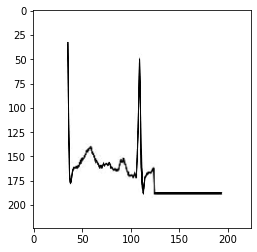

In [24]:
plt.imshow(test_generator[0][0][3])

In [25]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/S',
 '/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/F-resampled',
 '/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/M']

In [26]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [27]:
for layer in vgg.layers:
  layer.trainable = False

In [28]:
x = Flatten()(vgg.output)

In [29]:
prediction = Dense(len(folders), activation='softmax')(x)

In [30]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model1.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [32]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)

Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 0.7211 - accuracy: 0.7440
Epoch 1: val_accuracy improved from -inf to 0.84125, saving model to best_model1.h5
225/225 [==============================] - 49s 165ms/step - loss: 0.7211 - accuracy: 0.7440 - val_loss: 0.4469 - val_accuracy: 0.8413
Epoch 2/30
225/225 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8462
Epoch 2: val_accuracy improved from 0.84125 to 0.85708, saving model to best_model1.h5
225/225 [==============================] - 38s 170ms/step - loss: 0.4279 - accuracy: 0.8462 - val_loss: 0.4087 - val_accuracy: 0.8571
Epoch 3/30
225/225 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8829
Epoch 3: val_accuracy did not improve from 0.85708
225/225 [==============================] - 39s 172ms/step - loss: 0.3241 - accuracy: 0.8829 - val_loss: 0.4005 - val_accuracy: 0.8517
Epoch 4/30
225/225 [==============================] - ETA: 0s - loss: 0.2765 - accuracy:

In [34]:
vgg_model.save('best1.h5')

In [35]:
from keras.models import load_model
best_model1=load_model('/content/best1.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.36710
Test Accuracy: 91.37%


In [40]:
from keras.models import load_model
best_model2=load_model('/content/best_model1.h5')
results2 = best_model2.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results2[0]))
print("Test Accuracy: {:.2f}%".format(results2[1] * 100))

    Test Loss: 0.33886
Test Accuracy: 91.46%


Text(0, 0.5, 'loss')

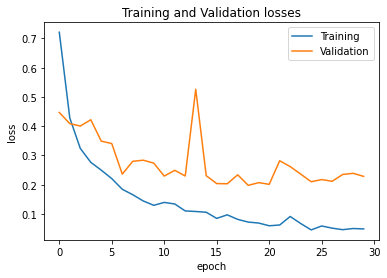

In [37]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

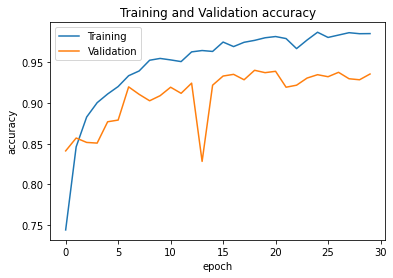

In [38]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [41]:
y_pred = best_model2.predict(test_generator)
y_pred

75/75 [==============================] - 13s 167ms/step


array([[9.86115336e-01, 7.50952750e-05, 4.45491448e-03, 1.24202859e-06,
        3.09489144e-04, 9.04390868e-03],
       [2.38811060e-13, 6.95415565e-08, 4.05687253e-08, 3.73705338e-11,
        9.99993324e-01, 6.59349416e-06],
       [8.46896172e-01, 7.85438679e-05, 1.32275313e-01, 9.58700639e-08,
        2.07080562e-02, 4.17902702e-05],
       ...,
       [1.65786332e-05, 3.06055099e-02, 9.68764663e-01, 6.01474585e-06,
        6.07201073e-04, 1.74990493e-08],
       [1.16011964e-10, 9.40430311e-09, 2.85580404e-06, 3.09826643e-03,
        1.69814200e-07, 9.96898770e-01],
       [2.64372269e-04, 7.03318883e-03, 9.76705730e-01, 7.34224959e-05,
        1.59126651e-02, 1.06848302e-05]], dtype=float32)

In [42]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 4, 0, ..., 2, 5, 2])

In [43]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[362   1   4   0   2  31]
 [  0 366  19   6   4   5]
 [  5  22 346   0  23   4]
 [  0   4   3 385   2   6]
 [  1   9  23   0 360   7]
 [  9   4   7   1   3 376]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       400
           1       0.90      0.92      0.91       400
           2       0.86      0.86      0.86       400
           3       0.98      0.96      0.97       400
           4       0.91      0.90      0.91       400
           5       0.88      0.94      0.91       400

    accuracy                           0.91      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92      0.91      0.91      2400



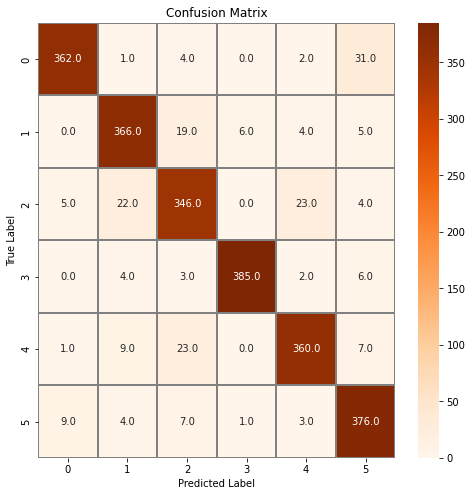

In [44]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [45]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 1s 820ms/step


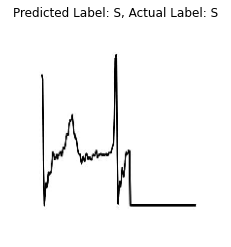

In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/S/115.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')

In [47]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [48]:
for layer in vgg.layers:
  layer.trainable = False

In [49]:
x = Flatten()(vgg.output)

In [50]:
prediction = Dense(len(folders), activation='softmax')(x)

In [51]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model2.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [53]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint,rp]
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.7315
Epoch 1: val_accuracy improved from -inf to 0.75250, saving model to best_model2.h5
225/225 [==============================] - 58s 256ms/step - loss: 0.7539 - accuracy: 0.7315 - val_loss: 0.5946 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8300
Epoch 2: val_accuracy improved from 0.75250 to 0.83917, saving model to best_model2.h5
225/225 [==============================] - 48s 211ms/step - loss: 0.4600 - accuracy: 0.8300 - val_loss: 0.4176 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8737
Epoch 3: val_accuracy improved from 0.83917 to 0.87750, saving model to best_model2.h5
225/225 [==============================] - 57s 252ms/step - loss: 0.3593 - accuracy: 0.8737 - val_loss: 0.3428 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 4/25
22

In [55]:
from keras.models import load_model
best_model3=load_model('/content/best_model2.h5')
results3 = best_model3.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results3[0]))
print("Test Accuracy: {:.2f}%".format(results3[1] * 100))

    Test Loss: 0.33135
Test Accuracy: 90.25%


Text(0, 0.5, 'loss')

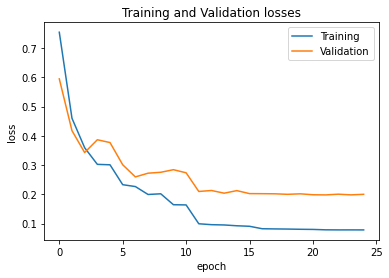

In [56]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

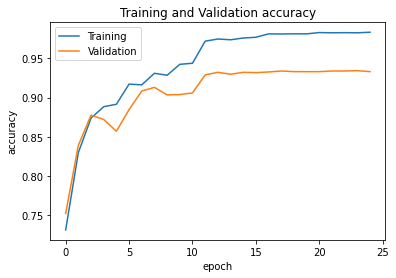

In [57]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [58]:
y_pred1 = best_model3.predict(test_generator)
y_pred1

75/75 [==============================] - 12s 155ms/step


array([[9.91792321e-01, 1.46384729e-04, 4.25843010e-03, 1.06697223e-06,
        5.24413423e-04, 3.27742496e-03],
       [1.18276496e-07, 4.20096711e-07, 6.37031826e-06, 5.10903986e-09,
        9.99962211e-01, 3.08899398e-05],
       [9.45404589e-01, 1.94213193e-04, 4.69354801e-02, 4.17236407e-07,
        7.40686338e-03, 5.84940026e-05],
       ...,
       [4.71761072e-04, 9.10653267e-03, 9.76210713e-01, 4.52252652e-06,
        1.42061794e-02, 2.63772591e-07],
       [2.34081952e-07, 6.86450562e-07, 6.83349033e-04, 3.37846428e-02,
        3.12338875e-06, 9.65528011e-01],
       [1.26275874e-03, 2.49804696e-03, 9.82578874e-01, 6.71382004e-05,
        1.35404691e-02, 5.27580196e-05]], dtype=float32)

In [59]:
y_pred1 = np.argmax(y_pred1, axis=1)
y_pred1

array([0, 4, 0, ..., 2, 5, 2])

In [60]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred1)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred1))

[[353   0  12   0   2  33]
 [  1 363  27   0   7   2]
 [  6  20 348   0  20   6]
 [  0   3   5 384   2   6]
 [  2   9  37   0 343   9]
 [  8   4   8   1   4 375]]
classification report
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       400
           1       0.91      0.91      0.91       400
           2       0.80      0.87      0.83       400
           3       1.00      0.96      0.98       400
           4       0.91      0.86      0.88       400
           5       0.87      0.94      0.90       400

    accuracy                           0.90      2400
   macro avg       0.91      0.90      0.90      2400
weighted avg       0.91      0.90      0.90      2400



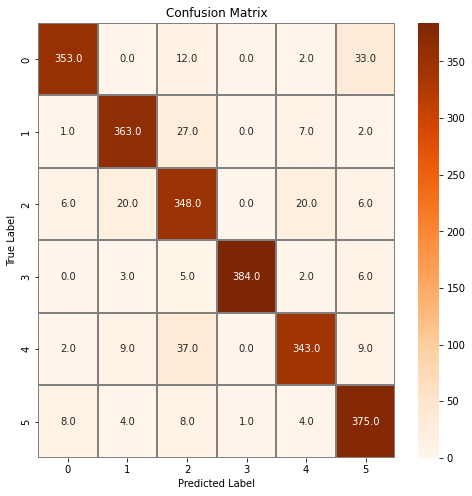

In [61]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [62]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 0s 151ms/step


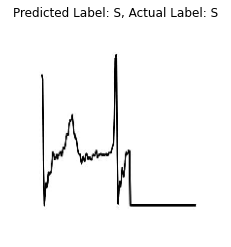

In [63]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/S/115.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model3.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')

In [64]:
model1=load_model('best_model1.h5')
model2=load_model('best_model2.h5')

In [65]:
model1=Model(inputs=model1.inputs,outputs=model1.outputs,name='VGG16')

In [66]:
model2=Model(inputs=model2.inputs,outputs=model2.outputs,name='VGG19')

In [67]:
models=[model1,model2]

In [68]:
model_input=Input(shape=(224,224,3))

In [69]:
model_outputs=[model(model_input) for model in models]

In [70]:
ensemble_output=Average()(model_outputs)

In [71]:
ensemble_model=Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [72]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model3.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [73]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [74]:
history=ensemble_model.fit(train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint])

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9739
Epoch 1: val_accuracy improved from -inf to 0.93708, saving model to best_model3.h5
225/225 [==============================] - 85s 372ms/step - loss: 0.1006 - accuracy: 0.9739 - val_loss: 0.1996 - val_accuracy: 0.9371
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9715
Epoch 2: val_accuracy did not improve from 0.93708
225/225 [==============================] - 83s 369ms/step - loss: 0.1075 - accuracy: 0.9715 - val_loss: 0.2056 - val_accuracy: 0.9342
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 0.93708
225/225 [==============================] - 83s 368ms/step - loss: 0.1052 - accuracy: 0.9689 - val_loss: 0.2126 - val_accuracy: 0.9304
Epoch 4/25
225/225 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9792
Epoch 4: val_accuracy improv

In [75]:
from keras.models import load_model
results1 = ensemble_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.37243
Test Accuracy: 92.50%


In [76]:
from keras.models import load_model
best_model4=load_model('/content/best_model3.h5')
results4 = best_model4.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results4[0]))
print("Test Accuracy: {:.2f}%".format(results4[1] * 100))

    Test Loss: 0.35953
Test Accuracy: 92.21%


Text(0, 0.5, 'loss')

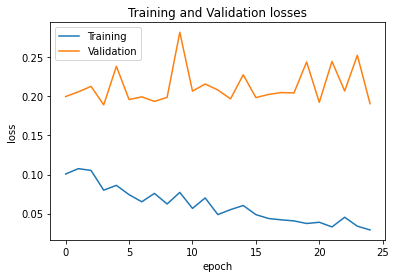

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

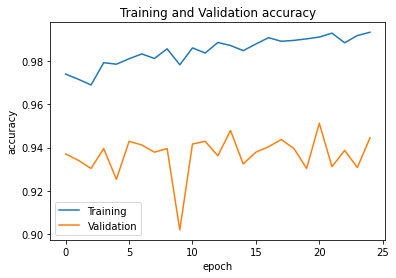

In [78]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [149]:
y_pred2 = results1.predict(test_generator)
y_pred2

AttributeError: ignored

In [150]:
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2

AxisError: ignored

In [81]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred2)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred2))

[[362   0   3   0   2  33]
 [  1 381   8   3   3   4]
 [  5  29 339   1  19   7]
 [  0   4   4 386   1   5]
 [  0  11  18   0 364   7]
 [  8   4   4   1   2 381]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       400
           1       0.89      0.95      0.92       400
           2       0.90      0.85      0.87       400
           3       0.99      0.96      0.98       400
           4       0.93      0.91      0.92       400
           5       0.87      0.95      0.91       400

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



In [81]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [82]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [83]:
for layer in resnet.layers:
  layer.trainable = False

In [84]:
x = Flatten()(resnet.output)

In [85]:
prediction = Dense(len(folders), activation='softmax')(x)

In [86]:
resnet_model = Model(inputs=resnet.input, outputs=prediction)

resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [87]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model4.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [88]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [89]:
result=resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 1.4140 - accuracy: 0.6253
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model4.h5
225/225 [==============================] - 43s 168ms/step - loss: 1.4140 - accuracy: 0.6253 - val_loss: 0.6888 - val_accuracy: 0.7500
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7811
Epoch 2: val_accuracy improved from 0.75000 to 0.77667, saving model to best_model4.h5
225/225 [==============================] - 35s 156ms/step - loss: 0.6246 - accuracy: 0.7811 - val_loss: 0.6333 - val_accuracy: 0.7767
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7887
Epoch 3: val_accuracy improved from 0.77667 to 0.77833, saving model to best_model4.h5
225/225 [==============================] - 35s 156ms/step - loss: 0.6658 - accuracy: 0.7887 - val_loss: 0.6645 - val_accuracy: 0.7783
Epoch 4/25
225/225 [==============================] 

In [90]:
resnet_model.save('best2.h5')

In [91]:
from keras.models import load_model
best_model5=load_model('/content/best_model4.h5')
results5 = best_model5.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results5[0]))
print("Test Accuracy: {:.2f}%".format(results5[1] * 100))

    Test Loss: 0.52688
Test Accuracy: 88.79%


In [92]:
from keras.models import load_model
best_model6=load_model('/content/best2.h5')
results6 = best_model4.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results6[0]))
print("Test Accuracy: {:.2f}%".format(results6[1] * 100))

    Test Loss: 0.35953
Test Accuracy: 92.21%


Text(0, 0.5, 'loss')

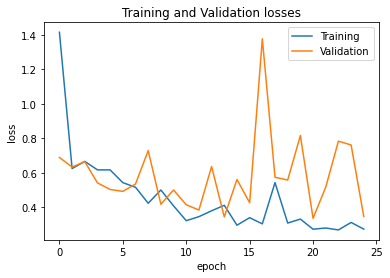

In [93]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

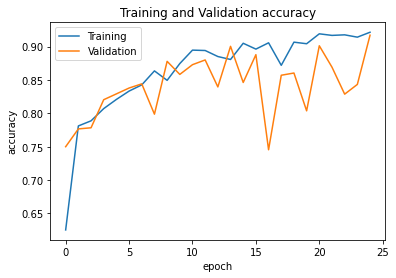

In [94]:


plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
     


In [95]:
y_pred3 = best_model5.predict(test_generator)
y_pred3

75/75 [==============================] - 10s 117ms/step


array([[9.9999416e-01, 1.3732901e-07, 5.5896539e-06, 4.1350773e-11,
        8.4402814e-09, 7.8114105e-08],
       [8.0412635e-13, 4.6623028e-10, 1.2133565e-10, 1.9874605e-14,
        1.0000000e+00, 2.0190496e-08],
       [9.9955314e-01, 1.4725393e-05, 4.1882848e-04, 4.3235981e-11,
        1.3247150e-05, 9.7503232e-09],
       ...,
       [2.9039086e-08, 3.2843899e-02, 9.6715075e-01, 5.1063522e-09,
        5.2798609e-06, 1.2355883e-10],
       [4.5487849e-18, 1.3906420e-10, 2.3844349e-09, 3.1783415e-07,
        1.8387514e-11, 9.9999964e-01],
       [2.3792363e-05, 4.1331705e-03, 9.9584007e-01, 5.5270800e-07,
        2.3255614e-06, 2.5780431e-10]], dtype=float32)

In [96]:
y_pred3 = np.argmax(y_pred3, axis=1)
y_pred3

array([0, 4, 0, ..., 2, 5, 2])

In [97]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred3)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred3))

[[375   1   5   0   0  19]
 [  0 379  14   1   4   2]
 [  9  61 313   3   9   5]
 [  0   7   1 389   2   1]
 [  5  29  37   2 318   9]
 [ 12  14   5  10   2 357]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       400
           1       0.77      0.95      0.85       400
           2       0.83      0.78      0.81       400
           3       0.96      0.97      0.97       400
           4       0.95      0.80      0.87       400
           5       0.91      0.89      0.90       400

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400



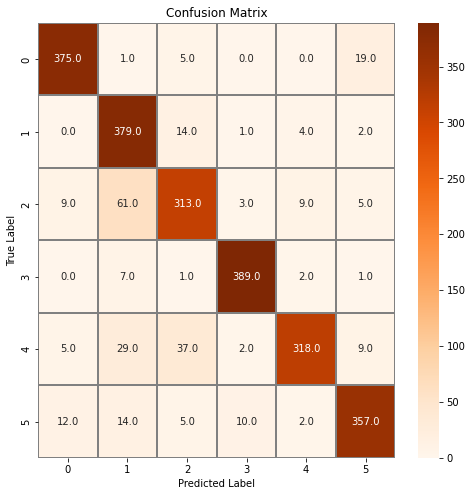

In [98]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Text(0, 0.5, 'accuracy')

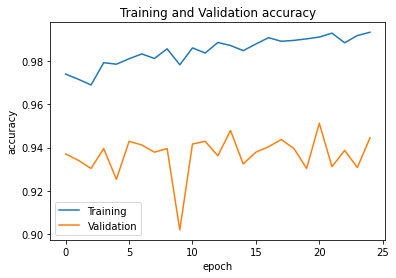

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [100]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred3)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred3))

[[375   1   5   0   0  19]
 [  0 379  14   1   4   2]
 [  9  61 313   3   9   5]
 [  0   7   1 389   2   1]
 [  5  29  37   2 318   9]
 [ 12  14   5  10   2 357]]
classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       400
           1       0.77      0.95      0.85       400
           2       0.83      0.78      0.81       400
           3       0.96      0.97      0.97       400
           4       0.95      0.80      0.87       400
           5       0.91      0.89      0.90       400

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400



In [101]:


class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)
     


{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 1s 1s/step


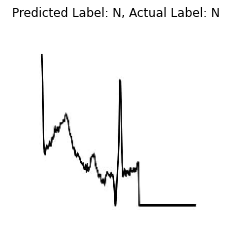

In [102]:
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/N/10015.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model5.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='N')

In [103]:
model3=load_model('/content/best_model4.h5')

In [104]:
model3=Model(inputs=model3.inputs,outputs=model3.outputs,name='resnet50')

In [130]:
models=[model1,model2,model3]

In [131]:
model_input=Input(shape=(224,224,3))

In [132]:
model_outputs=[model(model_input) for model in models]

In [133]:
ensemble_output=Average()(model_outputs)

In [134]:
ensemble_model=Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [136]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model5.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [137]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [138]:
history=ensemble_model.fit(train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint])

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9858
Epoch 1: val_accuracy improved from -inf to 0.93625, saving model to best_model5.h5
225/225 [==============================] - 124s 529ms/step - loss: 0.2296 - accuracy: 0.9858 - val_loss: 0.3753 - val_accuracy: 0.9362
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9907
Epoch 2: val_accuracy improved from 0.93625 to 0.93667, saving model to best_model5.h5
225/225 [==============================] - 128s 570ms/step - loss: 0.2405 - accuracy: 0.9907 - val_loss: 0.3611 - val_accuracy: 0.9367
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9924
Epoch 3: val_accuracy improved from 0.93667 to 0.94208, saving model to best_model5.h5
225/225 [==============================] - 117s 521ms/step - loss: 0.2316 - accuracy: 0.9924 - val_loss: 0.3635 - val_accuracy: 0.9421
Epoch 4/25
225/225 [=============================

In [139]:
from keras.models import load_model
results7 = ensemble_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results7[0]))
print("Test Accuracy: {:.2f}%".format(results7[1] * 100))

    Test Loss: 0.72383
Test Accuracy: 90.96%


In [140]:
from keras.models import load_model
best_model6=load_model('/content/best_model5.h5')
results8 = best_model6.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results8[0]))
print("Test Accuracy: {:.2f}%".format(results8[1] * 100))

    Test Loss: 0.65101
Test Accuracy: 91.79%


Text(0, 0.5, 'loss')

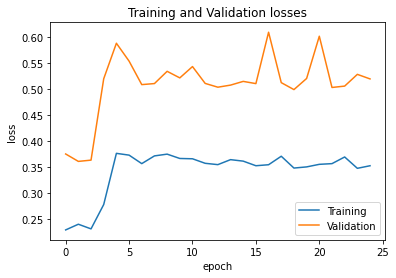

In [141]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

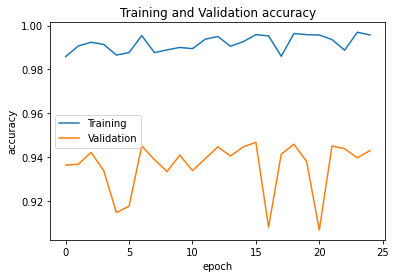

In [142]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [143]:
y_pred4 = best_model6.predict(test_generator)
y_pred4

75/75 [==============================] - 31s 367ms/step


array([[6.6661716e-01, 3.3829483e-07, 4.6530764e-05, 4.3139683e-11,
        6.6694031e-07, 3.3333537e-01],
       [1.5387564e-15, 1.0309947e-12, 9.2053253e-13, 1.8179217e-16,
        6.6666669e-01, 3.3333334e-01],
       [6.6216511e-01, 4.2700346e-08, 3.7842756e-03, 7.6637617e-14,
        7.1721594e-04, 3.3333334e-01],
       ...,
       [1.4982298e-08, 1.3974230e-03, 6.6523612e-01, 9.1252471e-11,
        3.3174234e-05, 3.3333334e-01],
       [4.8146335e-15, 5.7402125e-13, 7.6420577e-07, 2.3816375e-01,
        1.4015389e-11, 7.6183558e-01],
       [5.5217110e-06, 5.6288682e-04, 6.6192865e-01, 2.9736373e-07,
        4.1693533e-03, 3.3333334e-01]], dtype=float32)

In [144]:
y_pred4 = np.argmax(y_pred4, axis=1)
y_pred4

array([0, 4, 0, ..., 2, 5, 2])

In [145]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred4)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred4))

[[375   0   5   0   0  20]
 [  1 385   4   4   2   4]
 [  5  30 330   0  24  11]
 [  0   3   3 387   1   6]
 [  0  11  17   2 355  15]
 [ 10   4   4   5   6 371]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       400
           1       0.89      0.96      0.92       400
           2       0.91      0.82      0.87       400
           3       0.97      0.97      0.97       400
           4       0.91      0.89      0.90       400
           5       0.87      0.93      0.90       400

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



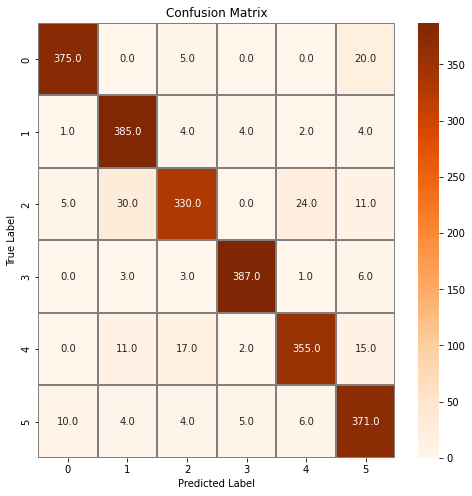

In [148]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [155]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_paths = ['best_model1.h5', 'best_model2.h5', 'best_model3.h5','best_model4.h5','best_model5.h5']

In [157]:
'''for model_path in model_paths:
    # Load the model
    model = load_model(model_path)

    # Make predictions on the test data
    y_pred = model.predict_generator(test_generator, verbose=1)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_generator.labels, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_path, roc_auc))

# Add labels and a legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

# Show the plot
plt.show()'''
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(test_generator.labels):
    fpr[i], tpr[i], _ = roc_curve(test_generator.classes == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot the ROC curve for each class
plt.figure()
colors = ['darkorange', 'green', 'blue', 'red', 'purple'] # add more colors as needed
for i, color in zip(range(test_generator.num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{} (AUC = {:.2f})'.format(test_generator.class_indices[i], roc_auc[i]))

# Add labels and a legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

# Show the plot
plt.show()

TypeError: ignored

In [ ]:
#model3=Model(inputs=model3.inputs,outputs=model3.outputs,name='CNN')

In [ ]:
#models=[model1,model3]

In [ ]:
#preds=[model.predict(test_generator) for model in models]

In [ ]:
#preds=np.array(preds)

In [ ]:
#summed=np.sum(preds,axis=0)

In [ ]:
#ensemble_prediction=np.argmax(summed,axis=1)

In [ ]:
#from sklearn.metrics import accuracy_score
#ensemble_accuracy=accuracy_score(test_generator.labels,ensemble_prediction)

In [ ]:
#print(ensemble_accuracy)

In [ ]:
#print(classification_report(test_generator.labels,ensemble_prediction))